# Generate G-Statistic Bootstrap Plots
### Setup

In [1]:
from __future__ import division

import os
from collections import defaultdict
from json import dumps, load

from pymongo import MongoClient
from pandas import DataFrame
from numpy import linspace

from cogent.maths.stats import chisqprob
from IPython.display import display, Image, Markdown

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S9')

In [3]:
try:
    os.mkdir('bootstraps')
except OSError:
    pass

### Utility

In [8]:
def get_blacklist():
    with open('blacklist.json') as bl:
        return load(bl)

def print_logs(log,  level='INFO'):
    printmd('##### ' + log.name)
    for d in log.find({'level':level}):
        printmd(dumps(d['message']))
        
def printmd(string):
    ''' thanks http://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown '''
    display(Markdown(string))

def get_pvalues(db, model, num=49):
    bootstraps = defaultdict(list)
    gstats = {}
    bl = get_blacklist()
    for colname in db.collection_names():
        if not colname.startswith(model+'_bootstraps'):
            continue
        col = getattr(db, colname)
        if colname.endswith('.log'):
            print_logs(col)
            continue
        for doc in col.find({'_id': {'$nin': bl}}):
            bootstraps[doc['_id']].extend(doc['gstats'])
            gstats[doc['_id']] = doc['gstat']
    pvalues = []
    for _id in gstats:
        assert len(bootstraps[_id]) >= num, _id + ' ' + str(bootstraps['_id'])
        pvalues.append((sum(gstats[_id] <= b for b in bootstraps[_id][:num]) + 1) / (num + 1))
    printmd('#### Loaded ' + str(len(pvalues)) + ' samples for ' + model + ' in ' + db.name)
    return pvalues

In [9]:
%%R
get_ggplot <- function(df)
{  
    df$model <- factor(df$model, levels=c('GNC', 'CNFGTR', 'Y98'))
    df$dataset <- factor(df$dataset, levels=c('Mammals', 'Ants', 'Vertebrates'))
    ggplot(df, aes(x=p)) +
        geom_histogram(binwidth=0.02, fill='white', colour='black') +
        xlab('G-statistic p-value') + # xlim(c(0,0.3)) +
        scale_y_sqrt() +
        facet_grid(dataset ~ model, space="free", scale="free")
}
get_cdf_plot <- function(df)
{
    df$model <- factor(df$model, levels=c('GNC', 'CNFGTR', 'Y98'))
    ggplot(df, aes(p, y, linetype=model)) + geom_line() +
        theme(legend.position = c(0.85, 0.15)) +
        ylab('Empirical CDF') + ylim(c(0.5,1.0)) +
        xlab('G-statistic p-value') + expand_limits(x=0.55)
}

### Load the Data

In [10]:
client = MongoClient()

In [11]:
datasets = ['mammals', 'ants', 'hum_xen_fug']
ds_map = {'mammals':'Mammals', 'ants':'Ants', 'hum_xen_fug':'Vertebrates'}
models = ['GNC', 'CNFGTR', 'Y98']
datasetlist = []
modellist = []
pvaluelist = []
ylist = []
rows = defaultdict(list)
for dataset in datasets:
    for model in models:
        db = getattr(client, dataset)
        pvalues = sorted(get_pvalues(db, model))
        pvaluelist.extend(pvalues)
        ylist.extend(linspace(0., 1., len(pvalues)).tolist())
        datasetlist.extend([ds_map[dataset]]*len(pvalues))
        modellist.extend([model]*len(pvalues))
        rows[model].append(100*sum(p<=0.05 for p in pvalues)/len(pvalues))
rejection = DataFrame(rows, index=[ds_map[d] for d in datasets], columns=models)
df = DataFrame({'p':pvaluelist, 'model':modellist, 'dataset':datasetlist, 'y':ylist})

##### GNC_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps"], "db_host": "r1021", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### GNC_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-2-7", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-2-7", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-2-7", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-2-7", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-2-7", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-2-7", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-1-5", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.GNC", "output_collection": "mammals.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.GNC_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

#### Loaded 4039 samples for GNC in mammals

##### CNFGTR_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.CNFGTR", "output_collection": "mammals.CNFGTR_bootstraps", "output_collections_file": null, "output_collections": ["mammals.CNFGTR_bootstraps"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.CNFGTR"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.CNFGTR", "output_collection": "mammals.CNFGTR_bootstraps", "output_collections_file": null, "output_collections": ["mammals.CNFGTR_bootstraps"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.CNFGTR"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.CNFGTR", "output_collection": "mammals.CNFGTR_bootstraps", "output_collections_file": null, "output_collections": ["mammals.CNFGTR_bootstraps"], "db_host": "r1021", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.CNFGTR"]}

##### CNFGTR_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.CNFGTR", "output_collection": "mammals.CNFGTR_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.CNFGTR_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.CNFGTR"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.CNFGTR", "output_collection": "mammals.CNFGTR_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.CNFGTR_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.CNFGTR"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.CNFGTR", "output_collection": "mammals.CNFGTR_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.CNFGTR_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.CNFGTR"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

#### Loaded 4039 samples for CNFGTR in mammals

##### Y98_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.Y98", "output_collection": "mammals.Y98_bootstraps", "output_collections_file": null, "output_collections": ["mammals.Y98_bootstraps"], "db_host": "r3405", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.Y98"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.Y98", "output_collection": "mammals.Y98_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.Y98_bootstraps2"], "db_host": "r150", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.Y98"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "mammals.Y98", "output_collection": "mammals.Y98_bootstraps2", "output_collections_file": null, "output_collections": ["mammals.Y98_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["mammals.Y98"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection": "0.0.9-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

#### Loaded 4039 samples for Y98 in mammals

##### GNC_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.GNC", "output_collection": "ants.GNC_bootstraps", "output_collections_file": null, "output_collections": ["ants.GNC_bootstraps"], "db_host": "r3512", "input_collections_file": null, "kwargs": {"num_bootstraps": 10, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### GNC_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.GNC", "output_collection": "ants.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["ants.GNC_bootstraps2"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### GNC_bootstraps3.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.GNC", "output_collection": "ants.GNC_bootstraps3", "output_collections_file": null, "output_collections": ["ants.GNC_bootstraps3"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

#### Loaded 2008 samples for GNC in ants

##### CNFGTR_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.CNFGTR", "output_collection": "ants.CNFGTR_bootstraps", "output_collections_file": null, "output_collections": ["ants.CNFGTR_bootstraps"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 10, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.CNFGTR"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.CNFGTR", "output_collection": "ants.CNFGTR_bootstraps2", "output_collections_file": null, "output_collections": ["ants.CNFGTR_bootstraps2"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.CNFGTR"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR_bootstraps3.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.CNFGTR", "output_collection": "ants.CNFGTR_bootstraps3", "output_collections_file": null, "output_collections": ["ants.CNFGTR_bootstraps3"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.CNFGTR"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

#### Loaded 2008 samples for CNFGTR in ants

##### Y98_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.Y98", "output_collection": "ants.Y98_bootstraps", "output_collections_file": null, "output_collections": ["ants.Y98_bootstraps"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 10, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.Y98"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.Y98", "output_collection": "ants.Y98_bootstraps2", "output_collections_file": null, "output_collections": ["ants.Y98_bootstraps2"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.Y98"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98_bootstraps3.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "ants.Y98", "output_collection": "ants.Y98_bootstraps3", "output_collections_file": null, "output_collections": ["ants.Y98_bootstraps3"], "db_host": "r3519", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["ants.Y98"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

#### Loaded 2008 samples for Y98 in ants

##### GNC_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.GNC", "output_collection": "hum_xen_fug.GNC_bootstraps", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC_bootstraps"], "db_host": "r1403", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.GNC", "output_collection": "hum_xen_fug.GNC_bootstraps", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC_bootstraps"], "db_host": "r1021", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.GNC"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### GNC_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.GNC", "output_collection": "hum_xen_fug.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.GNC", "output_collection": "hum_xen_fug.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.GNC", "output_collection": "hum_xen_fug.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC_bootstraps2"], "db_host": "r1567", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.GNC", "output_collection": "hum_xen_fug.GNC_bootstraps2", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC_bootstraps2"], "db_host": "r1567", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.GNC"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

#### Loaded 2008 samples for GNC in hum_xen_fug

##### CNFGTR_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.CNFGTR", "output_collection": "hum_xen_fug.CNFGTR_bootstraps", "output_collections_file": null, "output_collections": ["hum_xen_fug.CNFGTR_bootstraps"], "db_host": "r3405", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.CNFGTR"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.CNFGTR", "output_collection": "hum_xen_fug.CNFGTR_bootstraps2", "output_collections_file": null, "output_collections": ["hum_xen_fug.CNFGTR_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.CNFGTR"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

#### Loaded 2008 samples for CNFGTR in hum_xen_fug

##### Y98_bootstraps.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.Y98", "output_collection": "hum_xen_fug.Y98_bootstraps", "output_collections_file": null, "output_collections": ["hum_xen_fug.Y98_bootstraps"], "db_host": "r3405", "input_collections_file": null, "kwargs": {"num_bootstraps": 20, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.Y98"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98_bootstraps2.log

{"function": "ml.ml_bootstraps", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/dont_use_mpi.json", "input_collection": "hum_xen_fug.Y98", "output_collection": "hum_xen_fug.Y98_bootstraps2", "output_collections_file": null, "output_collections": ["hum_xen_fug.Y98_bootstraps2"], "db_host": "compute-0-0", "input_collections_file": null, "kwargs": {"num_bootstraps": 30, "use_mpi": false}, "log_name": "log", "input_collections": ["hum_xen_fug.Y98"]}

{"mong": "0.0.11-dev", "monglog": "0.0.2-dev", "map_collection_slowly": "0.0.1-dev", "masterslave": "0.0.11-dev", "ml": "0.0.11-dev"}

#### Loaded 2008 samples for Y98 in hum_xen_fug

### Generate the Plots

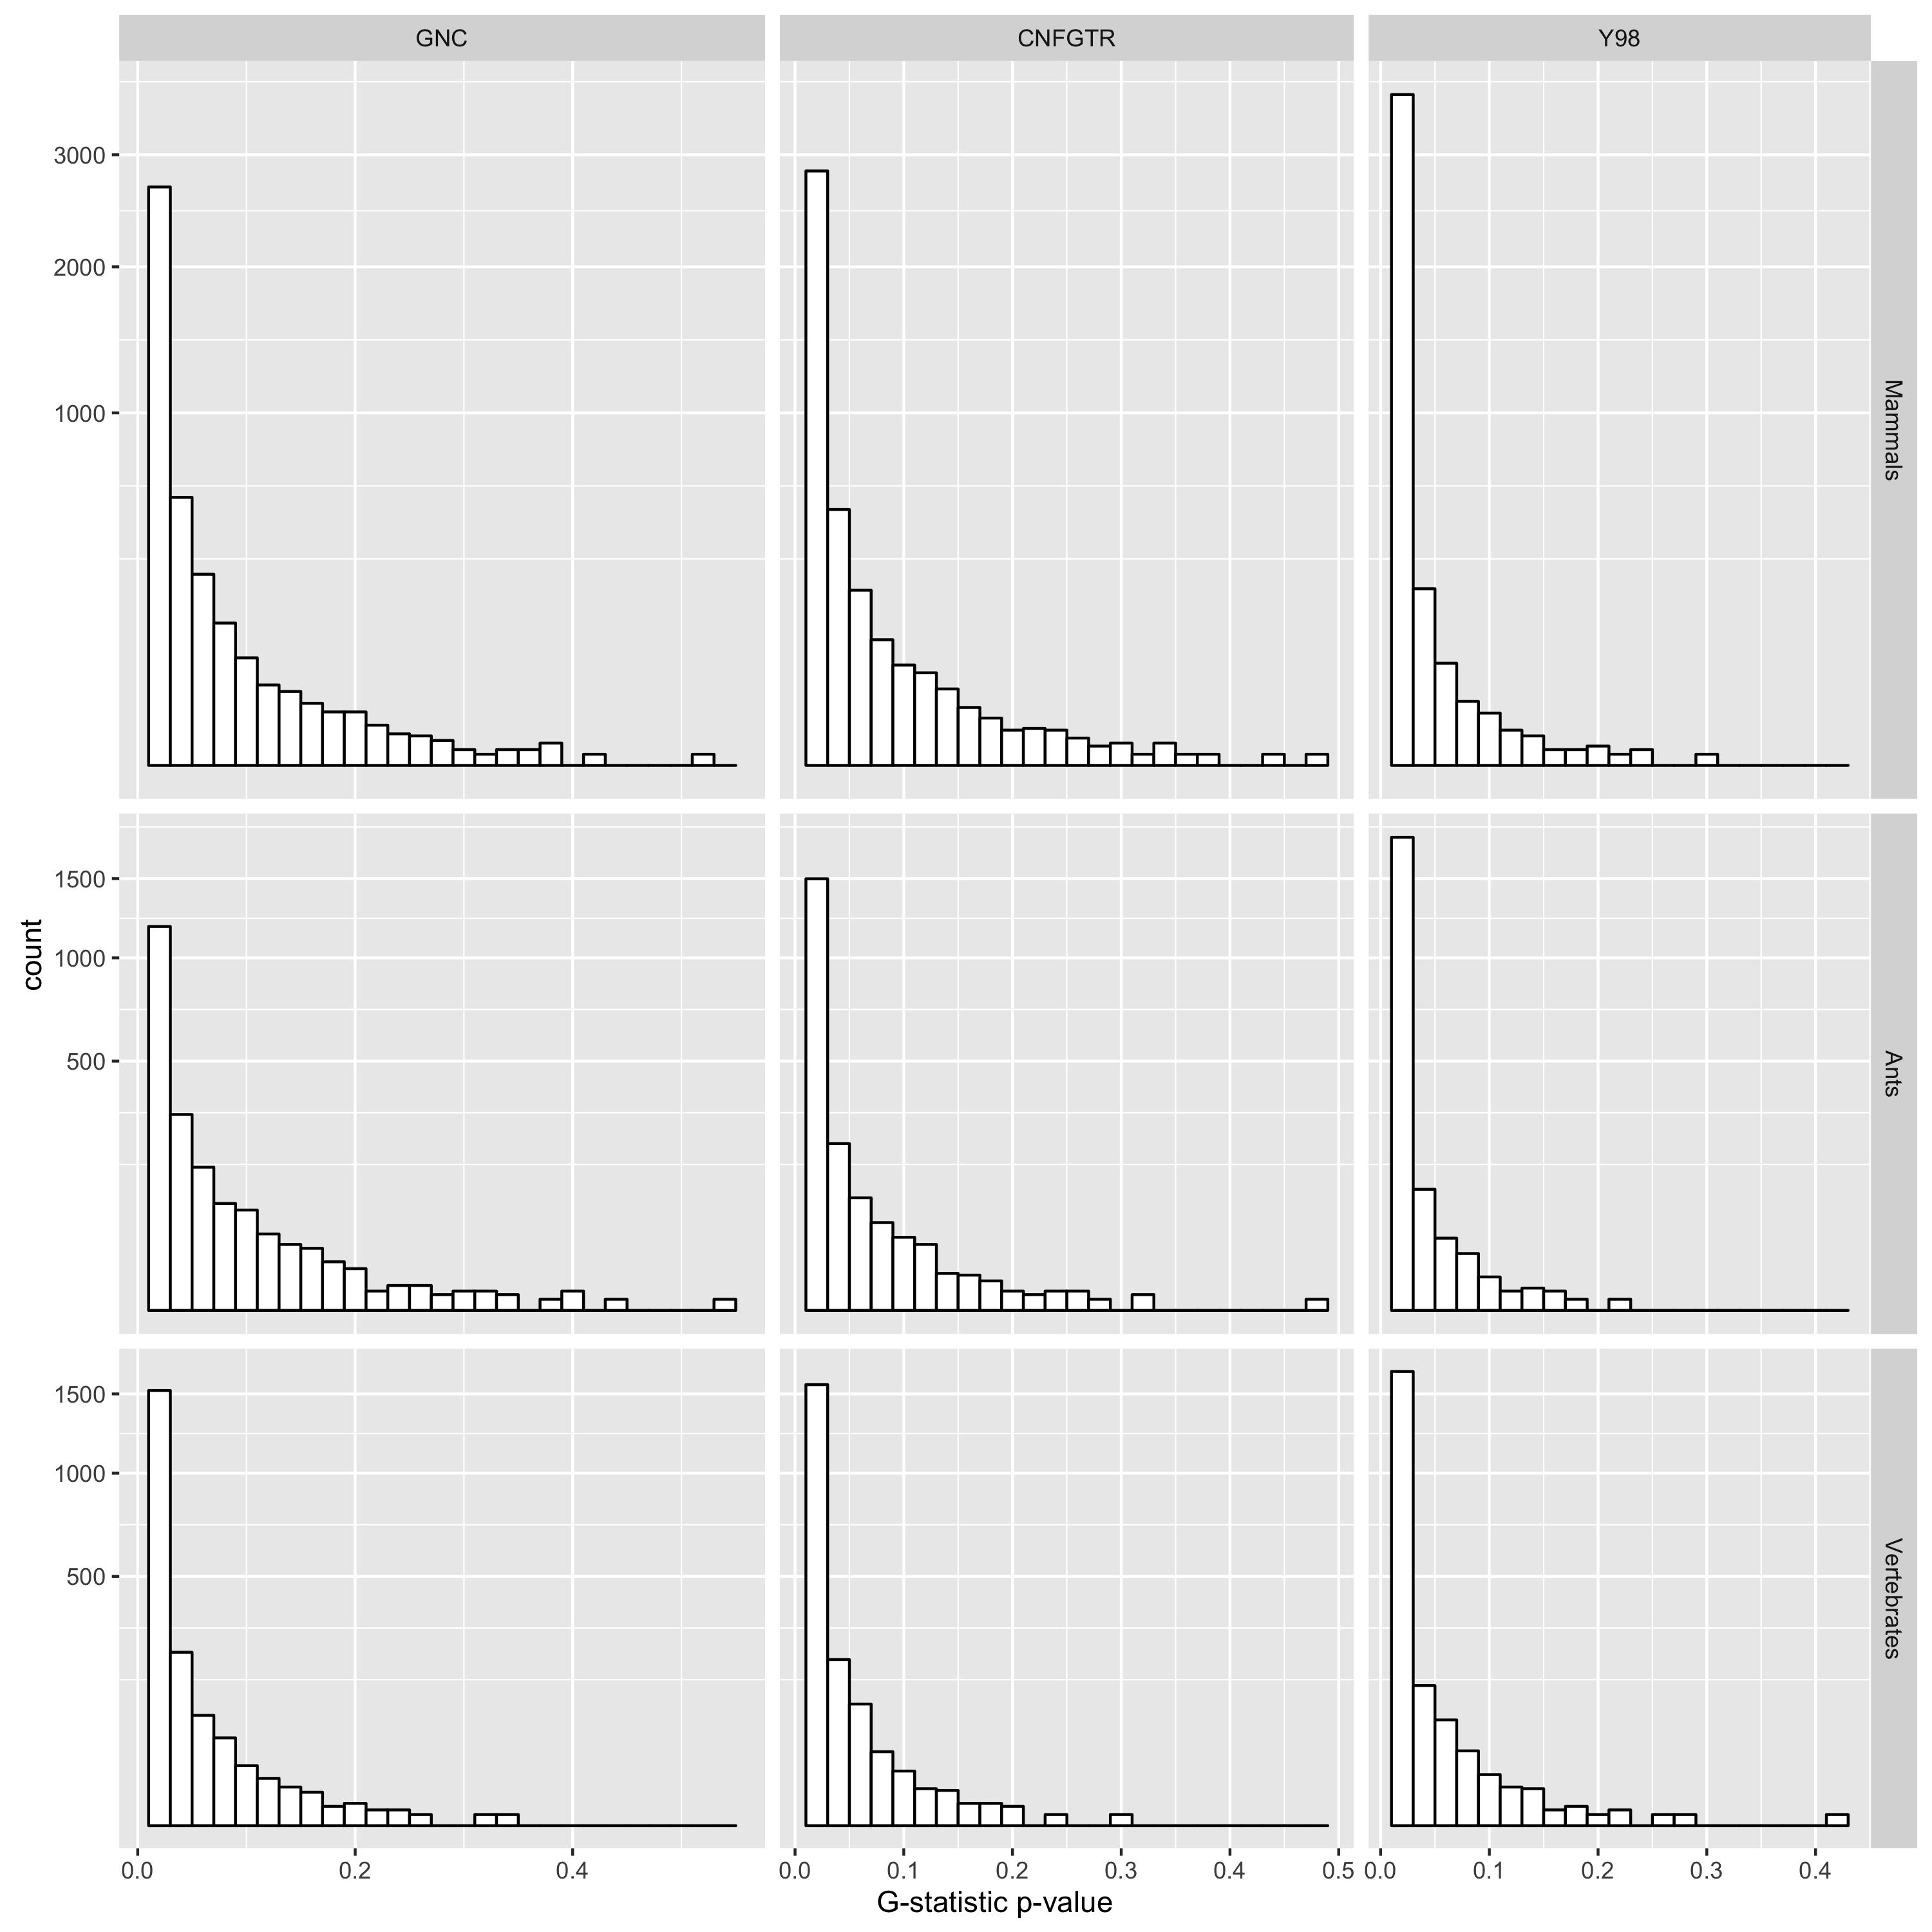

In [12]:
name = os.path.join('bootstraps', 'histograms.png')
%R -i df gg <- get_ggplot(df)
%R -i name ggsave(name, gg, width=10, height=10)
display(Image(name))

#### Mammals

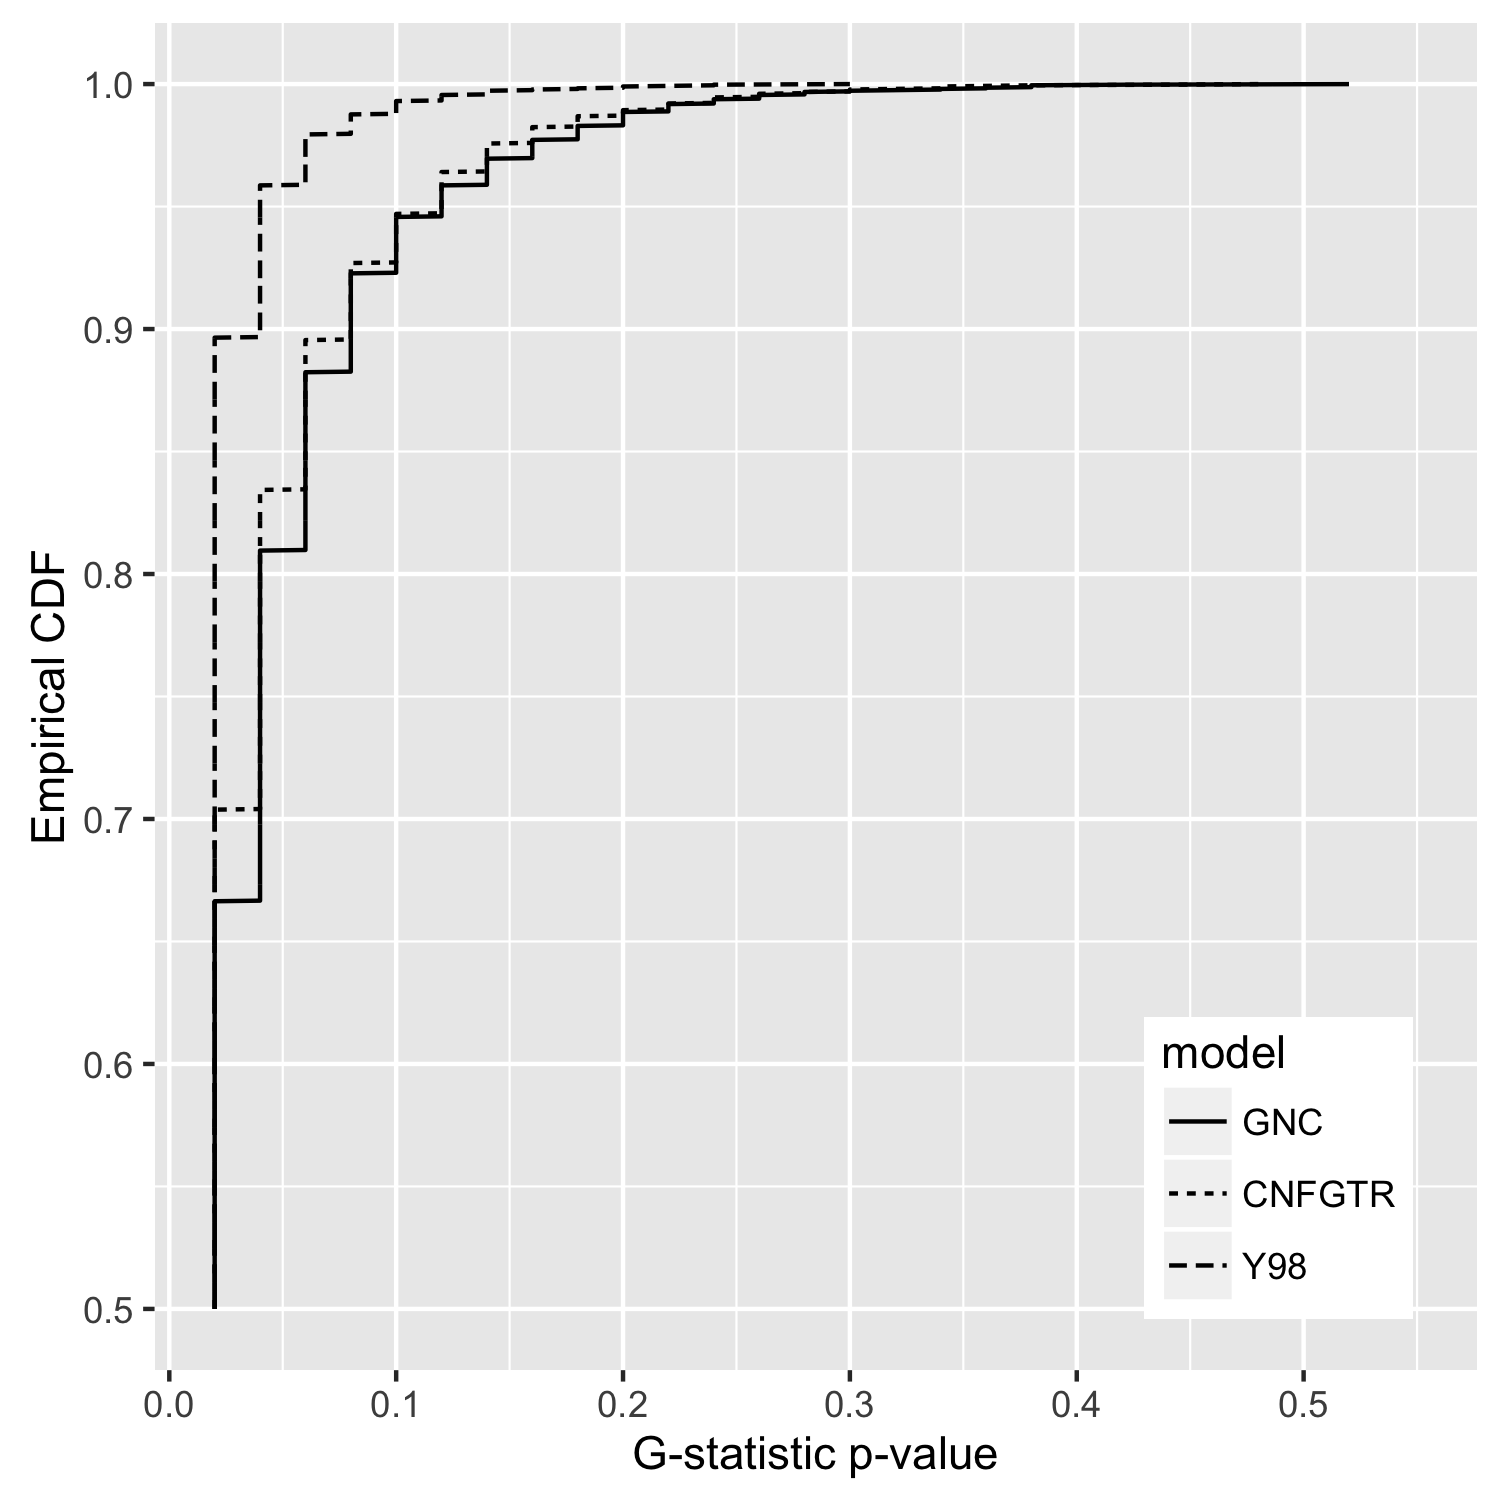

#### Vertebrates

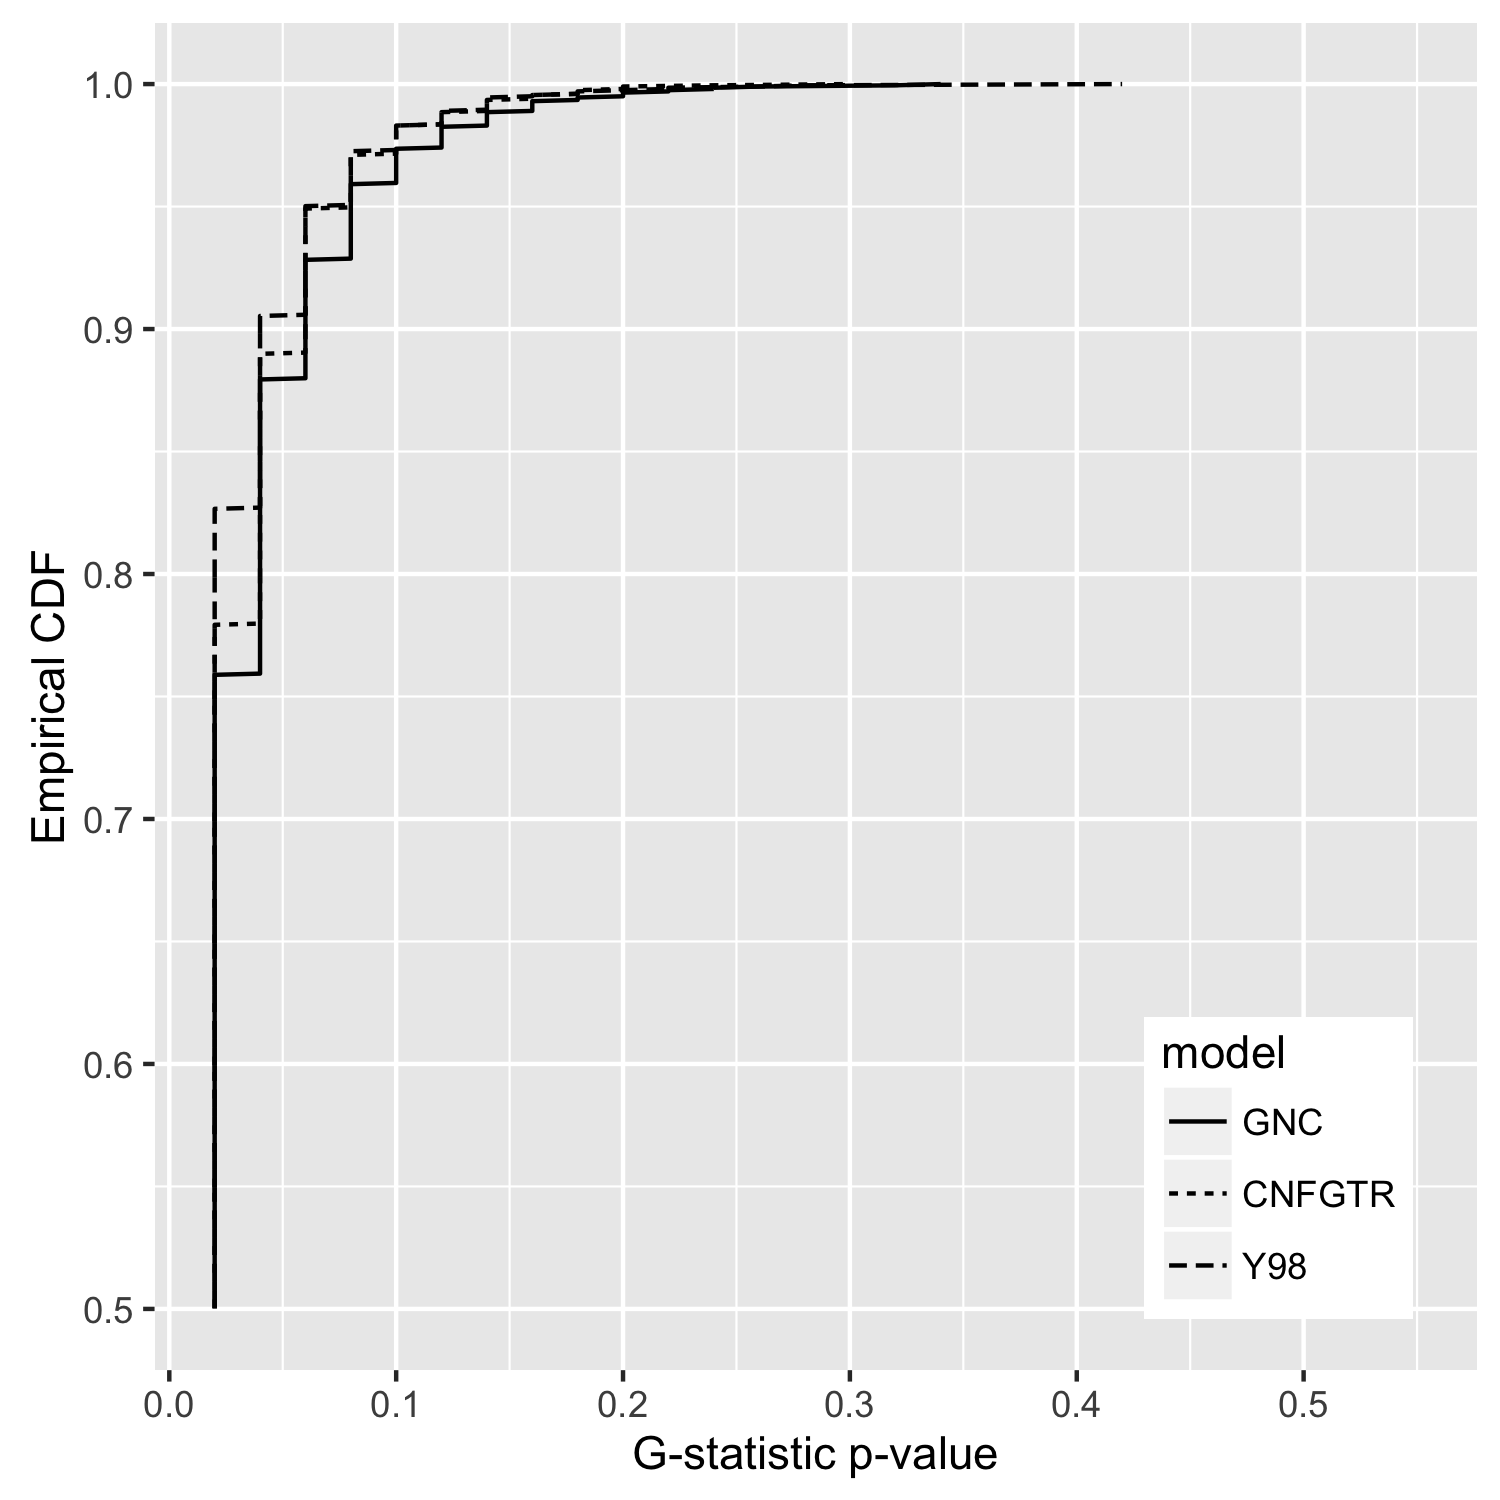

#### Ants

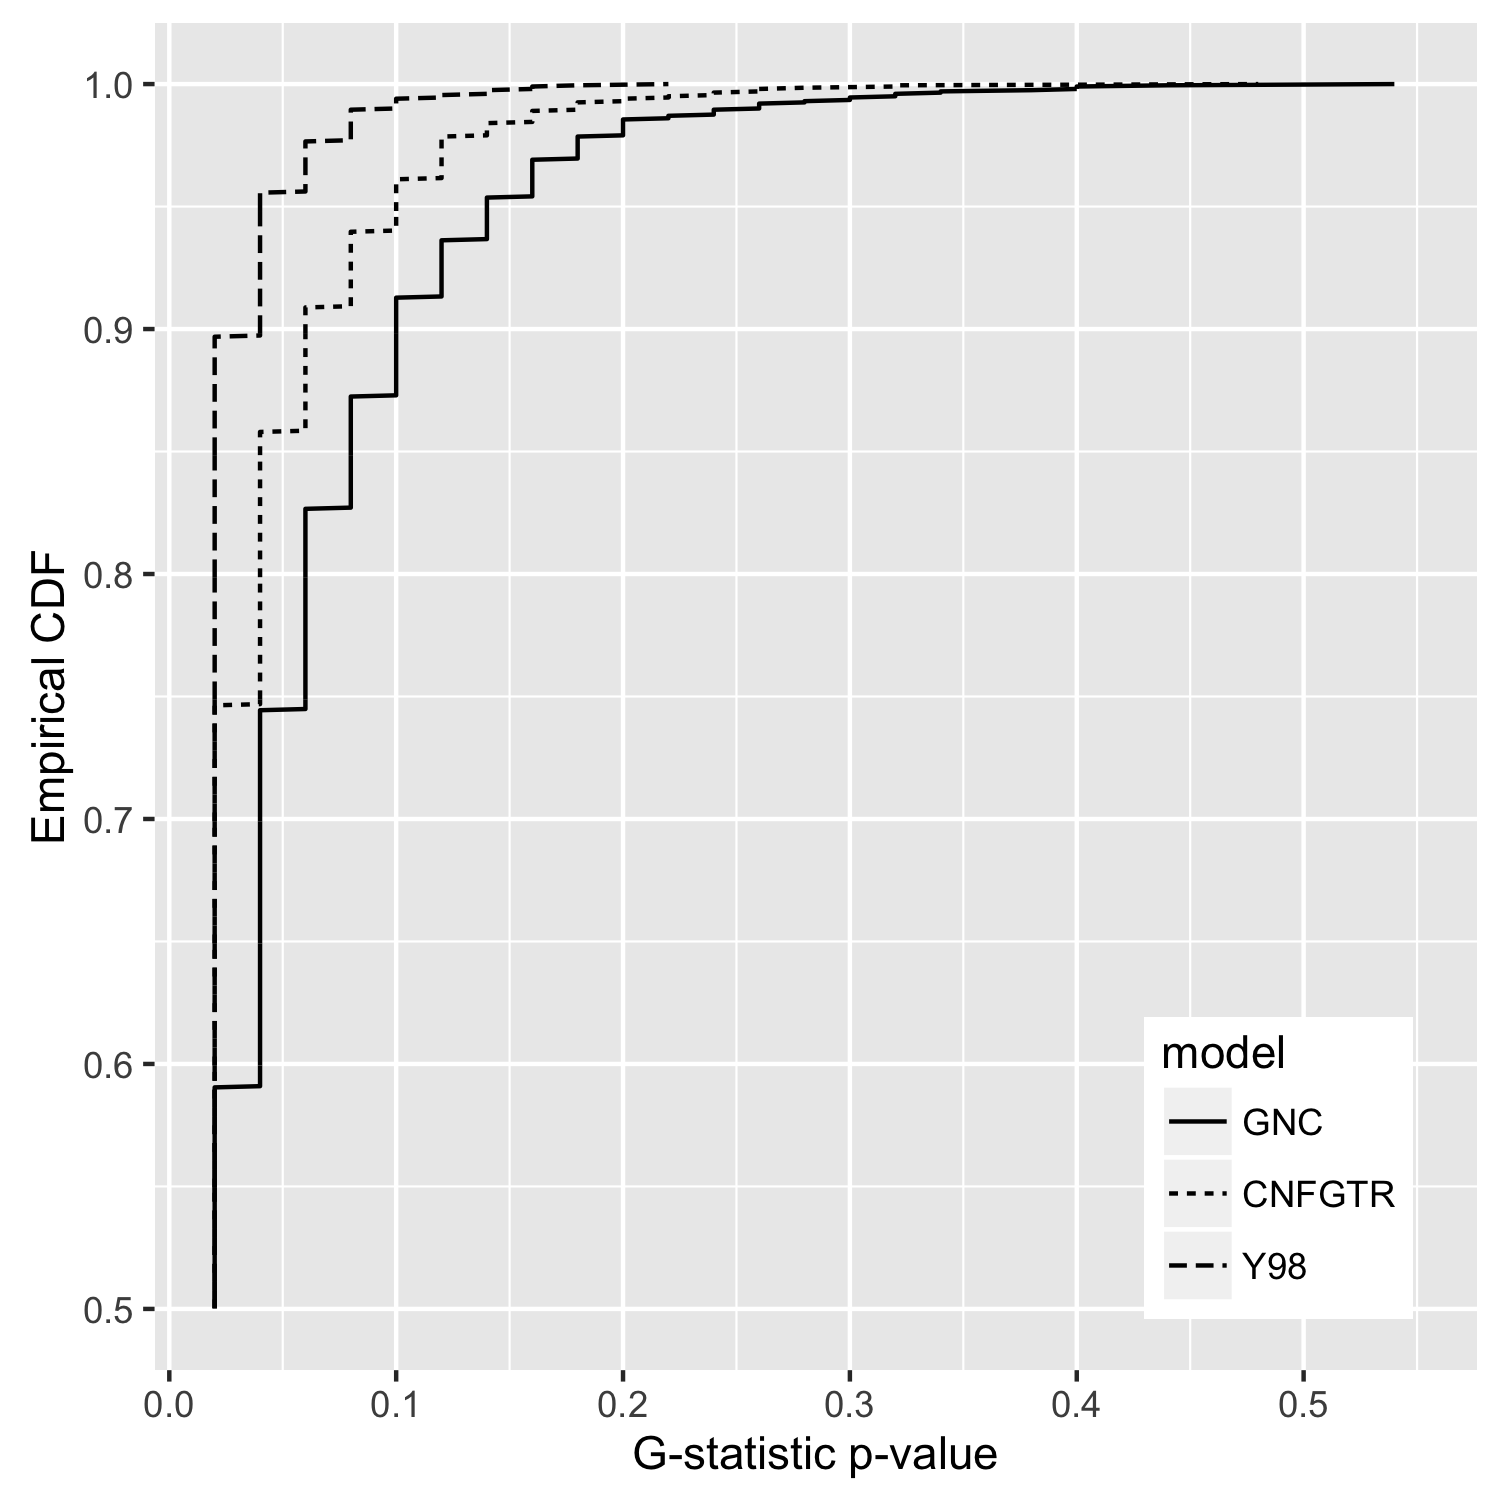

In [14]:
for ds in ds_map.values():
    dsdf = df[df['dataset'] == ds]
    name = os.path.join('bootstraps', ds + '.png')
    %R -i dsdf gg <- get_cdf_plot(dsdf)
    %R -i name ggsave(name, gg, width=5, height=5)
    printmd('#### ' + ds)
    display(Image(name))

### Print a Summary

In [15]:
rejection

,GNC,CNFGTR,Y98
Mammals,80.960634,83.436494,95.865313
Ants,74.452191,85.806773,95.567729
Vertebrates,87.948207,88.994024,90.537849


In [16]:
print rejection.to_latex(float_format=lambda x: '%.1f%%' % x)

\begin{tabular}{lrrr}
\toprule
{} &   GNC &  CNFGTR &   Y98 \\
\midrule
Mammals     & 81.0\% &   83.4\% & 95.9\% \\
Ants        & 74.5\% &   85.8\% & 95.6\% \\
Vertebrates & 87.9\% &   89.0\% & 90.5\% \\
\bottomrule
\end{tabular}



In [12]:
df[df['dataset'] == 'Vertebrates']

,dataset,model,p,y
18141,Vertebrates,GNC,0.02,0.000000
18142,Vertebrates,GNC,0.02,0.000498
18143,Vertebrates,GNC,0.02,0.000997
18144,Vertebrates,GNC,0.02,0.001495
18145,Vertebrates,GNC,0.02,0.001993
18146,Vertebrates,GNC,0.02,0.002491
18147,Vertebrates,GNC,0.02,0.002990
18148,Vertebrates,GNC,0.02,0.003488
18149,Vertebrates,GNC,0.02,0.003986
18150,Vertebrates,GNC,0.02,0.004484
